# Imports

In [1]:
import git
from numba import jit
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib_inline.backend_inline import set_matplotlib_formats
import pandas as pd
import geopandas as gp
from geopy.distance import geodesic
import ipywidgets as widgets
from tqdm.auto import tqdm
from itables import init_notebook_mode


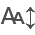

In [2]:
init_notebook_mode(all_interactive=True)

In [3]:
tqdm.pandas()
set_matplotlib_formats("svg")

https://geopandas.org/en/stable/getting_started.html

# Update

In [4]:
# print(git.Repo().submodule_update(init=True).module().git.pull())
# print(git.Repo().submodule_update(init=True).module().git.status())

# Load data

In [5]:
airports = pd.read_csv("ourairports-data/airports.csv", index_col="id")
runways = pd.read_csv("ourairports-data/runways.csv", index_col="id")
freqs = pd.read_csv("ourairports-data/airport-frequencies.csv", index_col="id")
countries = pd.read_csv("ourairports-data/countries.csv", index_col="id")
regions = pd.read_csv("ourairports-data/regions.csv", index_col="id")

# Search

In [6]:
icao_codes = tuple(airports["ident"].unique())
icao_selector = widgets.Combobox(
    options=icao_codes[:10000],
    value="EGCC",
    description="ICAO codes",
    disabled=False,
)
display(icao_selector)

Combobox(value='EGCC', description='ICAO codes', options=('00A', '00AA', '00AK', '00AL', '00AN', '00AS', '00AZ…

In [7]:
min_distance_selector = widgets.FloatLogSlider(
    value=100,
    description="Minimum distance",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
display(min_distance_selector)

FloatLogSlider(value=100.0, continuous_update=False, description='Minimum distance', readout_format='.1f')

In [8]:
max_distance_selector = widgets.FloatLogSlider(
    value=200,
    description="Maximum distance",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
display(max_distance_selector)

FloatLogSlider(value=200.0, continuous_update=False, description='Maximum distance', readout_format='.1f')

In [9]:
# Create a global button
git_button = widgets.Button(
    description="Git Pull",
    button_style="primary",  # Blue button
    tooltip="Click to pull from git",
    icon="arrow-down",
)

# Display the button
display(git_button)

Button(button_style='primary', description='Git Pull', icon='arrow-down', style=ButtonStyle(), tooltip='Click …

In [10]:
# Create a global button
update_button = widgets.Button(
    description="Update Data",
    button_style="primary",  # Blue button
    tooltip="Click to refresh all data",
    icon="refresh",
)

# Display the button
display(update_button)

Button(button_style='primary', description='Update Data', icon='refresh', style=ButtonStyle(), tooltip='Click …

In [11]:
# Output widgets for each function
freqs_output = widgets.Output()
runways_output = widgets.Output()
shortest_distances_output = widgets.Output()
range_distances_output = widgets.Output()
git_output = widgets.Output()

In [21]:
# Haversine distance (Numba JIT compiled for speed)
@jit(nopython=True, fastmath=True)
def haversine_bearing(lat1, lon1, lat2, lon2):
    R = 3440.065  # Radius of Earth in nautical miles
    
    # Convert all lat/lon values to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine distance
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    # Initial bearing calculation
    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(y, x))

    # Normalize bearing to 0-360 degrees
    bearing = (bearing + 360) % 360

    return distance, bearing

def update_all(_):
    global airports
    ident = icao_selector.value
    airport = airports.loc[airports["ident"] == ident]

    with freqs_output:
        freqs_output.clear_output(wait=True)
        display(freqs[freqs["airport_ident"] == ident].drop(["airport_ref"], axis=1))

    with runways_output:
        runways_output.clear_output(wait=True)
        display(runways[runways["airport_ident"] == ident]
                .drop(["airport_ref", "he_latitude_deg", "he_longitude_deg", "le_latitude_deg", "le_longitude_deg"], axis=1)
                .dropna(how="all", axis=1))

    # Extract target airport coordinates
    airport_lat, airport_lon = airport["latitude_deg"].values[0], airport["longitude_deg"].values[0]

    # Convert lat/lon to NumPy arrays for vectorized computation
    latitudes = airports["latitude_deg"].to_numpy()
    longitudes = airports["longitude_deg"].to_numpy()

    # Compute distances using Haversine formula (Numba optimized)
    distance_bearing = np.array([haversine_bearing(airport_lat, airport_lon, lat, lon) for lat, lon in zip(latitudes, longitudes)])

    # Assign distances and sort
    airports[["Distance","Bearing"]] = np.round(distance_bearing, 1)
    airports = airports.sort_values("Distance")

    # Reorder columns
    airports = airports[["Distance", "Bearing"]+list(airports.columns[:-2])]

    with shortest_distances_output:
        shortest_distances_output.clear_output(wait=True)
        display(airports.head(10))

    with range_distances_output:
        range_distances_output.clear_output(wait=True)
        display(
            airports[
                (airports["Distance"] >= min_distance_selector.value)
                & (airports["Distance"] <= max_distance_selector.value)
            ]
        )

# Attach function to button
update_button.on_click(update_all)

In [13]:
def update_git(_):
    with git_output:
        git_output.clear_output(wait=True)
        print(git.Repo().submodule_update(init=True).module().git.pull())
        # print(git.Repo().submodule_update(init=True).module().git.status())


# Attach the function to the button
git_button.on_click(update_git)

In [14]:
display(git_output)

Output()

In [15]:
display(freqs_output)

Output()

In [16]:
display(runways_output)

Output()

In [17]:
display(shortest_distances_output)

Output()

In [18]:
display(range_distances_output)

Output()

# Airports by country

In [19]:
airports.groupby("iso_country").nunique()

ident  type  name  latitude_deg  longitude_deg  elevation_ft  \
iso_country                                                                 
AD               3     2     3             3              3             1   
AE             255     6   250           253            254            69   
AF              79     4    79            79             79            66   
AG               6     3     6             6              6             4   
AI               2     2     2             2              2             1   
...            ...   ...   ...           ...            ...           ...   
YE              44     4    44            44             44            31   
YT               1     1     1             1              1             1   
ZA             652     6   651           647            651           495   
ZM             126     5   126           126            126            89   
ZW             155     5   155           155            154           109   

             continent  iso_region  municipality  scheduled_service  \
iso_country                                                           
AD                   1           2             2                  1   
AE                   1           8            84                  2   
AF                   1          29            64                  2   
AG                   0           4             5                  2   
AI                   0           1             2                  2   
...                ...         ...           ...                ...   
YE                   1          16            32                  2   
YT                   1           1             1                  1   
ZA                   1          10           499                  2   
ZM                   1          11           106                  2   
ZW                   1          10           110                  2   

             icao_code  iata_code  gps_code  local_code  home_link  \
iso_country                                                          
AD                   0          0         0           0          0   
AE                  12         15        27           2         10   
AF                  33         33        45           1          2   
AG                   2          2         4           0          0   
AI                   1          1         1           0          1   
...                ...        ...       ...         ...        ...   
YE                  15         22        23           3          0   
YT                   1          1         1           0          0   
ZA                  78         92       320           8         30   
ZM                  17         24        82           0          3   
ZW                  10         13        93           2          2   

             wikipedia_link  keywords  
iso_country                            
AD                        1         0  
AE                       26        12  
AF                       37        35  
AG                        3         2  
AI                        1         1  
...                     ...       ...  
YE                       19        11  
YT                        1         0  
ZA                       67        62  
ZM                       25         9  
ZW                       21        16  

[244 rows x 17 columns]

# Airports by elevation

<Axes: ylabel='Frequency'>

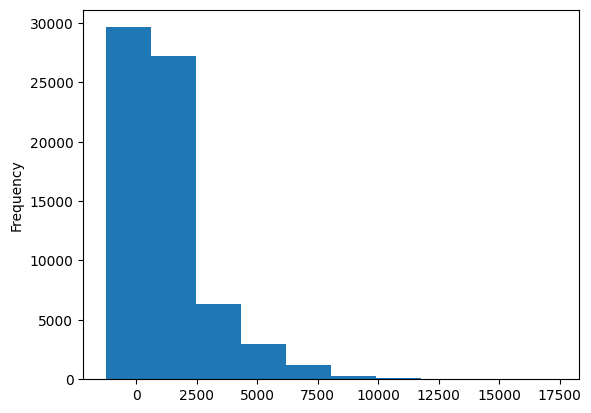

In [41]:
airports["elevation_ft"].plot.hist()

# Airports by ISO region

In [42]:
airports.groupby("iso_region").nunique()

ident  type  name  latitude_deg  longitude_deg  elevation_ft  \
iso_region                                                                 
AD-04           2     2     2             2              2             0   
AD-08           1     1     1             1              1             1   
AE-AJ          10     1    10            10             10             6   
AE-AZ         150     6   147           150            150            41   
AE-DU          24     5    22            23             23            10   
...           ...   ...   ...           ...            ...           ...   
ZW-MI          18     3    18            18             18            12   
ZW-MN          34     4    34            34             34            28   
ZW-MS          12     1    12            12             12             8   
ZW-MV          17     2    17            17             17            10   
ZW-MW          33     3    33            33             33            26   

            continent  iso_country  municipality  scheduled_service  \
iso_region                                                            
AD-04               1            1             1                  1   
AD-08               1            1             1                  1   
AE-AJ               1            1             3                  1   
AE-AZ               1            1            53                  2   
AE-DU               1            1             8                  2   
...               ...          ...           ...                ...   
ZW-MI               1            1            12                  1   
ZW-MN               1            1            21                  2   
ZW-MS               1            1            12                  1   
ZW-MV               1            1            12                  1   
ZW-MW               1            1            23                  1   

            icao_code  iata_code  gps_code  local_code  home_link  \
iso_region                                                          
AD-04               0          0         0           0          0   
AD-08               0          0         0           0          0   
AE-AJ               0          0         0           0          0   
AE-AZ               6          7        18           1          4   
AE-DU               3          5         3           0          5   
...               ...        ...       ...         ...        ...   
ZW-MI               1          1        12           1          0   
ZW-MN               3          3        14           0          0   
ZW-MS               0          0         7           0          0   
ZW-MV               2          2        10           1          1   
ZW-MW               1          2        23           0          1   

            wikipedia_link  keywords  
iso_region                            
AD-04                    0         0  
AD-08                    1         0  
AE-AJ                    0         0  
AE-AZ                   16         7  
AE-DU                    4         3  
...                    ...       ...  
ZW-MI                    3         1  
ZW-MN                    3         3  
ZW-MS                    0         0  
ZW-MV                    2         1  
ZW-MW                    2         5  

[2944 rows x 17 columns]

# Scheduled service

In [43]:
airports.groupby("scheduled_service").nunique()

ident  type   name  latitude_deg  longitude_deg  \
scheduled_service                                                    
no                 77915     7  73586         76877          77127   
yes                 4412     6   4400          4411           4410   

                   elevation_ft  continent  iso_country  iso_region  \
scheduled_service                                                     
no                         6243          6          228        2701   
yes                        1727          6          235        1676   

                   municipality  icao_code  iata_code  gps_code  local_code  \
scheduled_service                                                             
no                        34294       3873       4939     38822       32184   
yes                        4153       3751       4159      4268        1201   

                   home_link  wikipedia_link  keywords  
scheduled_service                                       
no                      3059           12116     17767  
yes                     1151            4255      1591

# Maps

In [44]:
world = gp.read_file("ne_10m_admin_0_countries.geojson")
# world.plot()

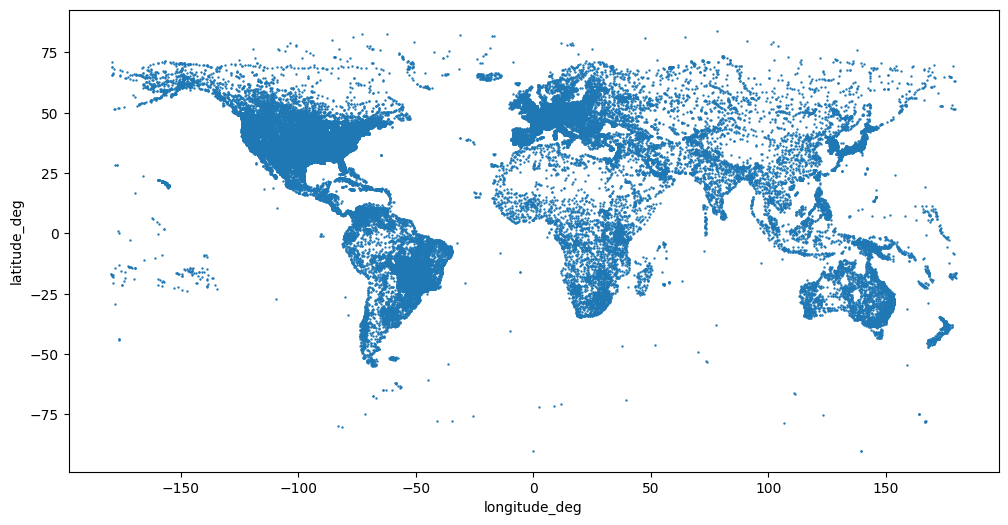

In [45]:
airports.plot.scatter(y="latitude_deg", x="longitude_deg", s=0.5, figsize=(12, 6))
plt.title("World Airports")
plt.show()

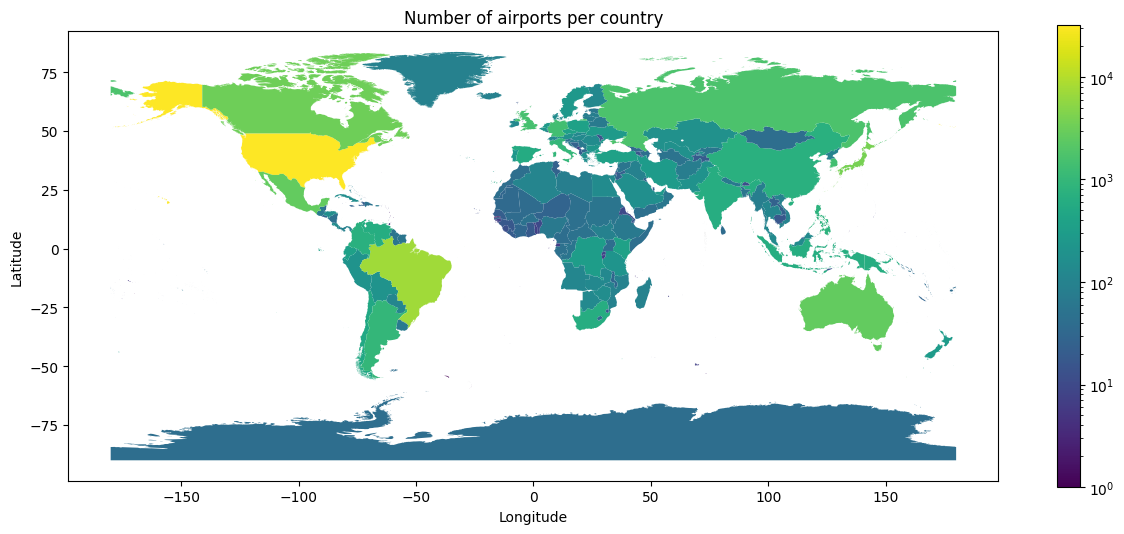

In [46]:
temp = airports.groupby("iso_country")["ident"].nunique()
world.merge(temp, right_index=True, left_on="ISO_A2", how="left").plot(
    "ident", legend=True, norm=LogNorm(), figsize=(15, 6)
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Number of airports per country")
plt.show()